In [31]:
import os
import sys
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from pystout import pystout
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [33]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [34]:
test = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv"
)

In [35]:
sentiment = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [36]:
# Import inflation probability data that is stored as a dta file
inflation_prob_us = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/USwestimates.dta"
)

inflation_prob_us = inflation_prob_us.rename(columns={"date_ym": "date"})

inflation_prob_eu = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/EZwestimates.dta"
)

inflation_prob_eu = inflation_prob_eu.rename(columns={"date_ym": "date"})

inflation_prob = inflation_prob_us.merge(
    inflation_prob_eu, on="date", how="left", suffixes=("_us", "_eu")
)

sentiment = sentiment.merge(inflation_prob, on="date", how="left")

# sentiment = sentiment.ffill()

In [37]:
inflation_diff = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Market Data/Inflation/12m cumulative inflation.xlsx"
)

print(inflation_diff.dtypes)

sentiment = pd.merge(sentiment, inflation_diff, on="date", how="left")

date               datetime64[ns]
12m_inf                   float64
target_distance           float64
high_inf                  float64
low_inf                   float64
dtype: object


In [38]:
indexes = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Other Data/Indexes/five_indexes.xlsx"
)
indexes["date"] = pd.to_datetime(indexes["date"])
sentiment = pd.merge(sentiment, indexes, how="left", left_on="date", right_on="date")

In [39]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")

In [40]:
# # HP Filter

url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    temp_dates = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
    temp_dates = pd.DataFrame(temp_dates, columns=["date"])
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]

    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sent = pd.merge(temp_dates, sent, how="left", left_on="date", right_on="date")

    # Set 'date' as the index for resampling
    sent.set_index("date", inplace=True)

    sent["sentiment"] = sent["sentiment"].ffill()

    # Resample to quarterly frequency
    sent = sent.resample("Q").mean()

    # Drop NaNs
    sent = sent.dropna(subset=["sentiment"])

    # Reset index to turn 'date' back into a column
    sent.reset_index(inplace=True)

    filter_df = sent.copy(deep=True)

    cycle, trend = sm.tsa.filters.hpfilter(filter_df["sentiment"], 1600)

    filter_df["sentiment_cycle"] = cycle
    filter_df["sentiment_trend"] = trend

    filter_df = filter_df[["date", "sentiment_cycle"]]
    sent = sent.drop(columns=["sentiment"])
    filter_df = filter_df.rename(columns={"sentiment_cycle": "sentiment"})
    sent = pd.merge(sent, filter_df, on="date", how="outer")
    sent = sent.groupby("date").mean().reset_index()

    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

In [41]:
fedfunds = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Fed Funds/Fed Funds.csv"
)
fedfunds["date"] = pd.to_datetime(fedfunds["date"])
sentiment = pd.merge(sentiment, fedfunds, how="left", left_on="date", right_on="date")

In [42]:
stocks = sentiment.copy(deep=True)
stocks = stocks[["date", "sp500_return", "stoxx"]]
stocks["log_returns"] = np.log(1 + stocks["sp500_return"])
stocks["log_returns_eu"] = np.log(1 + stocks["stoxx"])
stocks = stocks.resample("Q", on="date").sum().reset_index()

for i in range(0, 6):
    stocks[f"log_returns_{i}"] = stocks["log_returns"].shift(i)
    stocks[f"log_returns_eu_{i}"] = stocks["log_returns_eu"].shift(i)

In [43]:
# Resample the final 'sentiment' DataFrame to quarterly frequency
sentiment = sentiment.drop(columns=["sp500_return", "stoxx"])
sentiment = sentiment.resample("Q", on="date").mean().reset_index()

In [44]:
# merging FSI data
sentiment["fsi"] = (
    sentiment["credit"]
    + sentiment["equity_valuation"]
    + sentiment["safe_assets"]
    + sentiment["funding"]
    + sentiment["volatility"]
)

In [45]:
# Create lagged columns
for column in sentiment.columns:
    if column != "date":  # Skip the 'date' column
        sentiment[f"{column}_1"] = sentiment[column].shift(1)

max_lag = 15
for i in range(0, max_lag + 1):
    sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
    sentiment[f"fed_minutes_lag_{i}"] = sentiment["fed_minutes"].shift(i)
    sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
        -i
    )
    sentiment[f"press_conferences_lag_{i}"] = sentiment["press_conferences"].shift(i)
    sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
    sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
    sentiment[f"safe_assets_lag_{i}"] = sentiment["safe_assets"].shift(i)
    sentiment[f"funding_lag_{i}"] = sentiment["funding"].shift(i)
    sentiment[f"volatility_lag_{i}"] = sentiment["volatility"].shift(i)
    sentiment[f"fsi_lag_{i}"] = sentiment["fsi"].shift(i)
    sentiment[f"fsi_forward_{i}"] = sentiment["fsi"].shift(-i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_8444/226821499.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_8444/226821499.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_8444/226821499.py:16: PerformanceWarning: DataFrame is highly fragmented.  This i

In [46]:
sentiment = pd.merge(sentiment, stocks, how="left", left_on="date", right_on="date")

In [47]:
# sentiment = sentiment[
#     (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-30")
# ]

sentiment = sentiment[
    (sentiment["date"] >= "2000-06-01") & (sentiment["date"] <= "2022-06-30")
]

In [48]:
# Export sentiment as csv
sentiment.to_csv(f"{database}/Sentiment.csv", index=False)

In [49]:
print(sentiment.columns)

Index(['date', 'date_stata_us', 'higher4_5y5y_us', 'higher5_5y5y_us',
       'lower0_5y5y_us', 'lowerm1_5y5y_us', 'zc_higher4_5y_us',
       'zc_higher5_5y_us', 'zc_lower0_5y_us', 'zc_lowerm1_5y_us',
       ...
       'log_returns_1', 'log_returns_eu_1', 'log_returns_2',
       'log_returns_eu_2', 'log_returns_3', 'log_returns_eu_3',
       'log_returns_4', 'log_returns_eu_4', 'log_returns_5',
       'log_returns_eu_5'],
      dtype='object', length=331)


In [50]:
# Define the independent variables for each regression
x = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "fsi_1",
]

yvar0 = "fsi"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Sentiment Index Regressed on ECB Sentiment")
stargazer.custom_columns(
    [
        "FSI. (t)",
    ]
)

stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_lag_1",
        "press_conferences_lag_2",
        "press_conferences_lag_3",
        "press_conferences_lag_4",
        "fsi_1",
    ]
)

stargazer.rename_covariates(
    {
        "press_conferences": "ECB  Sent. (t)",
        "press_conferences_lag_1": "ECB  Sent. (t-1)",
        "press_conferences_lag_2": "ECB  Sent. (t-2)",
        "press_conferences_lag_3": "ECB  Sent. (t-3)",
        "press_conferences_lag_4": "ECB  Sent. (t-4)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Sentiment Index Regressed on ECB Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\hline
\hline \
& \multicolumn{1}{c}{\textit{Dependent variable: fsi}} \
\cr \cline{2-2}
\ & \multicolumn{1}{c}{FSI. (t)}  \\
\hline \
 ECB  Sent. (t) & -13.022$^{***}$ \\
& (4.481) \\
 ECB  Sent. (t-1) & 7.644$^{**}$ \\
& (3.582) \\
 ECB  Sent. (t-2) & 2.751$^{}$ \\
& (3.020) \\
 ECB  Sent. (t-3) & 3.377$^{}$ \\
& (3.275) \\
 ECB  Sent. (t-4) & -0.440$^{}$ \\
& (2.592) \\
 fsi_1 & 0.785$^{***}$ \\
& (0.075) \\
\hline \
 Observations & 88 \\
 $R^2$ & 0.713 \\
 Adjusted $R^2$ & 0.691 \\
 Residual Std. Error & 2.492 (df=81) \\
 F Statistic & 26.956$^{***}$ (df=6; 81) \\
\hline
\hline \
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [51]:
# Define the independent variables for each regression
x = [
    "fsi",
    "fsi_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fsi",
        "fsi_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "fsi": "Financial Sentiment Index",
        "fsi_1": "Financial Sentiment Index (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Financial Sentiment Index & -0.012$^{***}$ & -0.008$^{***}$ & -0.008$^{***}$ & -0.009$^{***}$ & -0.004$^{}$ \\
& (0.003) & (0.003) & (0.002) & (0.003) & (0.005) \\
 Financial Sentiment Index (t-1) & 0.006$^{**}$ & -0.001$^{}$ & -0.000$^{}$ & 0.002$^{}$ & -0.002$^{}$ \\
& (0.003) & (0.004) & (0.004) & (0.004) & (0.004) \\
 ECB Sent. (t-1) & 0.560$^{***}$ & 0.123$^{}$ & 0.051$^{}$ & -0.032$^{}$ & -0.202$^{}$ \\
& (0.075) & (0.109) & (0.119) & (0.127) & (0.128) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.478 & 0.203 & 0.154 & 0.107 & 0.073 \\
 Adjusted $R^2$ & 0.459 & 0.175 & 0.124 & 0.076 & 0.040 \\
 Residual Std. E

In [52]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Minute Sentiment Regressed on Financial Sentiment Index Credit")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Minute Sentiment Regressed on Financial Sentiment Index Credit}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Credit & -0.039$^{***}$ & -0.030$^{***}$ & -0.032$^{***}$ & -0.029$^{**}$ & -0.017$^{}$ \\
& (0.011) & (0.010) & (0.007) & (0.012) & (0.017) \\
 Credit (t-1) & 0.023$^{**}$ & 0.005$^{}$ & 0.010$^{}$ & 0.009$^{}$ & -0.002$^{}$ \\
& (0.011) & (0.012) & (0.010) & (0.013) & (0.017) \\
 ECB Sent. (t-1) & 0.553$^{***}$ & 0.128$^{}$ & 0.063$^{}$ & -0.048$^{}$ & -0.214$^{*}$ \\
& (0.079) & (0.110) & (0.117) & (0.125) & (0.127) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.468 & 0.219 & 0.163 & 0.107 & 0.092 \\
 Adjusted $R^2$ & 0.449 & 0.191 & 0.133 & 0.076 & 0.059 \\
 Residual Std. Error & 0.076 (df=84) & 0.0

In [53]:
# Define the independent variables for each regression
x = [
    "equity_valuation",
    "equity_valuation_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index Equity Valuation")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "equity_valuation",
        "equity_valuation_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Equity Valuation & -0.083$^{***}$ & -0.055$^{**}$ & -0.038$^{**}$ & -0.034$^{*}$ & -0.015$^{}$ \\
& (0.017) & (0.021) & (0.015) & (0.021) & (0.021) \\
 Equity Valuation (t-1) & 0.035$^{*}$ & 0.002$^{}$ & -0.008$^{}$ & -0.008$^{}$ & -0.030$^{}$ \\
& (0.019) & (0.019) & (0.020) & (0.023) & (0.026) \\
 ECB Sent. (t-1) & 0.622$^{***}$ & 0.232$^{**}$ & 0.132$^{}$ & 0.011$^{}$ & -0.172$^{}$ \\
& (0.074) & (0.104) & (0.110) & (0.113) & (0.126) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.496 & 0.149 & 0.079 & 0.043 & 0.049 \\
 Adjusted $R^2$ & 0.478 & 0.119 & 0.046 & 0.009 & 0.015 \\
 Residual Std. Error 

In [54]:
# Define the independent variables for each regression
x = [
    "safe_assets",
    "safe_assets_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index Safe Assets")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "safe_assets",
        "safe_assets_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Safe Assets}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Safe Assets & -0.031$^{}$ & 0.035$^{}$ & 0.018$^{}$ & -0.016$^{}$ & -0.064$^{*}$ \\
& (0.032) & (0.041) & (0.035) & (0.045) & (0.039) \\
 Safe Assets (t-1) & 0.030$^{}$ & -0.048$^{}$ & -0.054$^{}$ & -0.035$^{}$ & 0.017$^{}$ \\
& (0.033) & (0.043) & (0.038) & (0.042) & (0.039) \\
 ECB Sent. (t-1) & 0.600$^{***}$ & 0.258$^{***}$ & 0.160$^{}$ & 0.033$^{}$ & -0.107$^{}$ \\
& (0.074) & (0.096) & (0.098) & (0.101) & (0.102) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.362 & 0.085 & 0.056 & 0.038 & 0.052 \\
 Adjusted $R^2$ & 0.340 & 0.052 & 0.022 & 0.004 & 0.018 \\
 Residual Std. Error & 0.083 (df=84) & 0.099 

In [55]:
# Define the independent variables for each regression
x = [
    "funding",
    "funding_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index Funding")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "funding",
        "funding_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Funding}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Funding & -0.017$^{*}$ & -0.020$^{***}$ & -0.028$^{***}$ & -0.036$^{*}$ & -0.013$^{}$ \\
& (0.009) & (0.005) & (0.009) & (0.019) & (0.017) \\
 Funding (t-1) & -0.004$^{}$ & -0.012$^{}$ & -0.002$^{}$ & 0.014$^{}$ & -0.004$^{}$ \\
& (0.009) & (0.008) & (0.010) & (0.013) & (0.011) \\
 ECB Sent. (t-1) & 0.537$^{***}$ & 0.155$^{}$ & 0.087$^{}$ & 0.015$^{}$ & -0.149$^{}$ \\
& (0.075) & (0.095) & (0.106) & (0.108) & (0.111) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.411 & 0.200 & 0.160 & 0.114 & 0.049 \\
 Adjusted $R^2$ & 0.389 & 0.172 & 0.130 & 0.082 & 0.015 \\
 Residual Std. Error & 0.080 (df=84) & 0.093 (df=8

In [56]:
# Define the independent variables for each regression
x = [
    "volatility",
    "volatility_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index Volatility")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "volatility",
        "volatility_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Volatility}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Volatility & -0.032$^{***}$ & -0.019$^{**}$ & -0.019$^{***}$ & -0.019$^{*}$ & -0.009$^{}$ \\
& (0.007) & (0.008) & (0.007) & (0.010) & (0.010) \\
 Volatility (t-1) & 0.015$^{**}$ & -0.004$^{}$ & -0.002$^{}$ & 0.004$^{}$ & -0.005$^{}$ \\
& (0.007) & (0.009) & (0.011) & (0.009) & (0.010) \\
 ECB Sent. (t-1) & 0.546$^{***}$ & 0.144$^{}$ & 0.069$^{}$ & -0.021$^{}$ & -0.171$^{}$ \\
& (0.073) & (0.109) & (0.121) & (0.134) & (0.128) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.469 & 0.151 & 0.101 & 0.056 & 0.036 \\
 Adjusted $R^2$ & 0.450 & 0.121 & 0.068 & 0.023 & 0.002 \\
 Residual Std. Error & 0.076 (df=84) &

In [57]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("ECB Sentiment Regressed on Financial Sentiment Index Variables")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "press_conferences_1": "ECB Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Credit & -0.006$^{}$ & -0.024$^{}$ & -0.043$^{}$ & -0.030$^{}$ & -0.060$^{**}$ \\
& (0.022) & (0.031) & (0.029) & (0.028) & (0.026) \\
 Credit (t-1) & -0.000$^{}$ & -0.004$^{}$ & 0.009$^{}$ & -0.016$^{}$ & 0.006$^{}$ \\
& (0.016) & (0.026) & (0.024) & (0.023) & (0.025) \\
 Equity Valuation & -0.064$^{**}$ & -0.044$^{}$ & 0.013$^{}$ & 0.023$^{}$ & 0.037$^{}$ \\
& (0.028) & (0.038) & (0.038) & (0.040) & (0.035) \\
 Equity Valuation (t-1) & 0.040$^{}$ & 0.043$^{}$ & 0.009$^{}$ & 0.003$^{}$ & -0.011$^{}$ \\
& (0.026) & (0.032) & (0.034) & (0.037) & (0.033) \\
 Safe Assets & 0.003$^{}$ & 0.042$^{}$ & 0.017$^{}$ & -0.023$^{}$ & -0

In [58]:
# Define the independent variables for each regression
x0 = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "credit_lag_1",
]

x1 = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "equity_valuation_lag_1",
]

x2 = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "safe_assets_lag_1",
]

x3 = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "funding_lag_1",
]

x4 = [
    "press_conferences",
    "press_conferences_lag_1",
    "press_conferences_lag_2",
    "press_conferences_lag_3",
    "press_conferences_lag_4",
    "volatility_lag_1",
]


yvar0 = "credit"
yvar1 = "equity_valuation"
yvar2 = "safe_assets"
yvar3 = "funding"
yvar4 = "volatility"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x0]).dropna()
exog1 = sm.add_constant(sentiment[x1]).dropna()
exog2 = sm.add_constant(sentiment[x2]).dropna()
exog3 = sm.add_constant(sentiment[x3]).dropna()
exog4 = sm.add_constant(sentiment[x4]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Stress Index Regressed on Fed Minutes Sentiment")
stargazer.custom_columns(
    [
        "Credit (t)",
        "Equity Valuation (t)",
        "Safe Assets (t)",
        "Funding (t)",
        "Volatility (t)",
    ]
)

stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_lag_1",
        "press_conferences_lag_2",
        "press_conferences_lag_3",
        "press_conferences_lag_4",
        "credit_lag_1",
        "equity_valuation_lag_1",
        "safe_assets_lag_1",
        "funding_lag_1",
        "volatility_lag_1",
    ]
)

stargazer.rename_covariates(
    {
        "press_conferences": "ECB Sent. (t)",
        "press_conferences_lag_1": "ECB Sent. (t-1)",
        "press_conferences_lag_2": "ECB Sent. (t-2)",
        "press_conferences_lag_3": "ECB Sent. (t-3)",
        "press_conferences_lag_4": "ECB Sent. (t-4)",
        "credit_lag_1": "Credit (t-1)",
        "equity_valuation_lag_1": "Equity Valuation (t-1)",
        "safe_assets_lag_1": "Safe Assets (t-1)",
        "funding_lag_1": "Funding (t-1)",
        "volatility_lag_1": "Volatility (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Stress Index Regressed on Fed Minutes Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Credit (t)} & \multicolumn{1}{c}{Equity Valuation (t)} & \multicolumn{1}{c}{Safe Assets (t)} & \multicolumn{1}{c}{Funding (t)} & \multicolumn{1}{c}{Volatility (t)}  \\
\hline \
 ECB Sent. (t) & -3.279$^{***}$ & -2.538$^{***}$ & -0.243$^{}$ & -1.585$^{**}$ & -5.456$^{***}$ \\
& (1.007) & (0.684) & (0.324) & (0.801) & (1.918) \\
 ECB Sent. (t-1) & 1.882$^{**}$ & 1.239$^{**}$ & 0.036$^{}$ & 0.480$^{}$ & 2.562$^{*}$ \\
& (0.864) & (0.624) & (0.401) & (0.969) & (1.407) \\
 ECB Sent. (t-2) & 1.002$^{}$ & 0.426$^{}$ & 0.152$^{}$ & 1.357$^{*}$ & -0.092$^{}$ \\
& (0.875) & (0.607) & (0.410) & (0.700) & (1.200) \\
 ECB Sent. (t-3) & 1.292$^{}$ & 1.155$^{}$ & -0.304$^{}$ & 0.436$^{}$ & 0.936$^{}$ \\
& (0.926) & (0.713) & (0.409) & (0.790) & (1.230) \\
 ECB Sent. (t-4) & 0.346$^{}$ & 0.006$^{}$ & 0.378$^{}$ & 0.322$^{}

In [59]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "ECB Sentiment Regressed on Financial Sentiment Index Credit and Equity Valuation"
)
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit (t)",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation (t)",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "press_conferences_1": "Press Conferences (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{ECB Sentiment Regressed on Financial Sentiment Index Credit and Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Credit (t) & -0.008$^{}$ & -0.024$^{}$ & -0.046$^{***}$ & -0.040$^{*}$ & -0.033$^{}$ \\
& (0.010) & (0.017) & (0.015) & (0.021) & (0.027) \\
 Credit (t-1) & -0.003$^{}$ & -0.003$^{}$ & 0.019$^{}$ & 0.016$^{}$ & 0.012$^{}$ \\
& (0.009) & (0.018) & (0.016) & (0.018) & (0.024) \\
 Equity Valuation (t) & -0.069$^{***}$ & -0.013$^{}$ & 0.030$^{}$ & 0.025$^{}$ & 0.035$^{}$ \\
& (0.025) & (0.033) & (0.028) & (0.034) & (0.034) \\
 Equity Valuation (t-1) & 0.045$^{*}$ & 0.022$^{}$ & -0.006$^{}$ & -0.006$^{}$ & -0.027$^{}$ \\
& (0.024) & (0.025) & (0.027) & (0.029) & (0.033) \\
 Press Conferences (t-1) & 0.583$^{***}

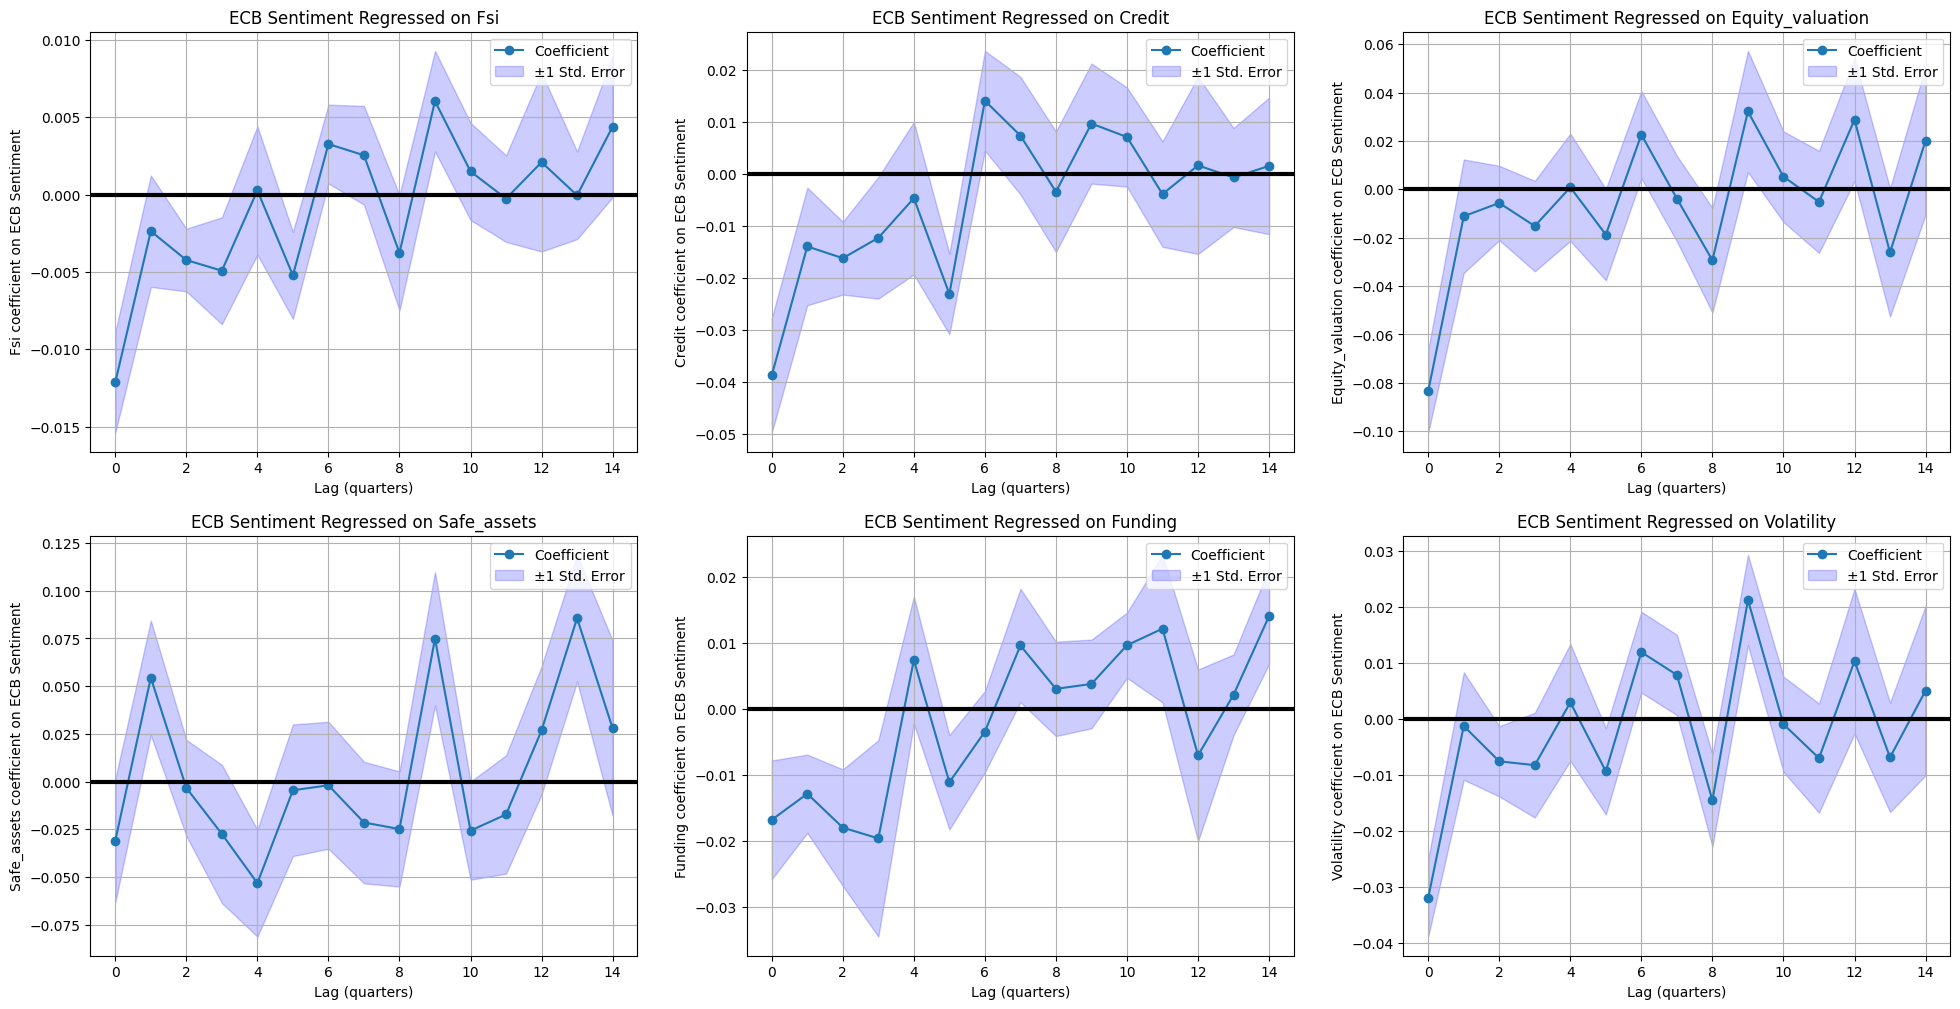

In [60]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    "fsi",
    "credit",
    "equity_valuation",
    "safe_assets",
    "funding",
    "volatility",
]

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

for idx, var in enumerate(variables):
    coefs = []
    ses = []
    lags = []
    for lag in range(max_lag):
        lag_1 = lag + 1
        var_lag = f"{var}_lag_{lag}"
        x = [
            f"{var}_lag_{lag}",
            f"{var}_lag_{lag_1}",
            "press_conferences_lag_1",
        ]
        yvar0 = "press_conferences"
        exog0 = sm.add_constant(sentiment[x]).dropna()
        y = sentiment[yvar0].loc[exog0.index]
        try:
            reg0 = sm.OLS(endog=y, exog=exog0).fit(cov_type="HC0")
            coefs.append(reg0.params[var_lag])
            ses.append(reg0.bse[var_lag])
        except Exception:
            coefs.append(np.nan)
            ses.append(np.nan)
        lags.append(lag)
    coefs = np.array(coefs)
    ses = np.array(ses)
    ax = axes[idx]
    ax.plot(lags, coefs, marker="o", label="Coefficient")
    ax.fill_between(
        lags, coefs - ses, coefs + ses, color="blue", alpha=0.2, label="±1 Std. Error"
    )
    ax.set_xlabel("Lag (quarters)")
    ax.set_ylabel(f"{var.capitalize()} coefficient on ECB Sentiment")
    ax.set_title(f"ECB Sentiment Regressed on {var.capitalize()}")
    ax.grid(True)
    ax.legend()
    # Add thick black bar at y=0
    ax.axhline(y=0, color="black", linewidth=3)